#### Imports

In [1]:
import time
now = time.time()
import os
import sys
import numpy as np
import urllib

# import BlazingSQL
try:
    from blazingsql import BlazingContext
    print("You're good to go!")
# looks like we don't have it installed
except ImportError:
    # see if we want to install it
    ask = input('Unable to import BlazingSQL package, would you like to install it now? (y/n) ')
    if ask.lower().strip() == 'y':
        from utils.sql_check import bsql_start
        print(bsql_start())
    else:
        # not installing at this time
        _ = 'Ok, you can find the script here: https://docs.blazingdb.com/docs/install-via-conda'
        _ = _ + ' or run utils/sql_check.py if you would like to install it in the future.'
        # what can I do if I change my mind?
        print(_)
        del _

You're good to go!


## Check for / Download Data
- Full data download Wall time: 4min 43s on AWS 
- 20.07 GB total (12 CSV files)

In [2]:
%%time
# 2015 taxi data bucket
base_url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
# jan - december
for i in range(1, 13):
    # check if we are in double digit months
    if len(str(i)) < 2:
        # we're in single digits, add 0 in front
        i = f'0{i}'
    # tag file name for this month
    fn = f'yellow_tripdata_2015-{i}.csv'
    # check if we already have the file
    if not os.path.isfile('data/' + fn):
        # we don't let me know we're downloading it now
        print(f'Downloading {base_url + fn} to data/{fn}')
        # download file
        urllib.request.urlretrieve(base_url + fn, 'data/' + fn)
    # we already have data
    else:
        # let us know
        print(f'data/{fn} already downloaded')

CPU times: user 49 s, sys: 1min 1s, total: 1min 50s
Wall time: 4min 9s


# ETL - Clean Data

#### Start up BlazingSQL

In [3]:
%%time
# connect to BlazingSQL
bc = BlazingContext()

BlazingContext ready
CPU times: user 1.28 s, sys: 489 ms, total: 1.77 s
Wall time: 3.12 s


#### Create Tables

In [4]:
%%time
# create tables for all 12 CSV files
for i in range(1, 13):
    # are we in double digits yet?
    if i < 10:
        # add 0 so we have the correct path
        i = f'0{i}'
    # tag path to this month's data
    data_path = f'{os.getcwd()}/data/yellow_tripdata_2015-{i}.csv'
    # create a table for this month
    bc.create_table(f'taxi_{i}', data_path, header=0)

CPU times: user 73.4 ms, sys: 28.5 ms, total: 102 ms
Wall time: 108 ms


#### Define query & functions

In [5]:
%%time
# tag default shift
origin_shift = 2 * np.pi * 6378137 / 2.0

# filter data to select lat & longitude regions and rename lat/lng columns
focus = f'''
        SELECT 
            VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
            trip_distance, RatecodeID, store_and_fwd_flag, payment_type, fare_amount,
            extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, 
            pickup_longitude * {origin_shift} / 180 AS pickup_x, 
            TAN(((90 + pickup_latitude) * {np.pi} / 360)) AS pickup_y,
            dropoff_longitude * {origin_shift} / 180 AS dropoff_x, 
            TAN(((90 + dropoff_latitude) * {np.pi} / 360)) AS dropoff_y
        FROM 
            big_taxi
            WHERE
                pickup_longitude < -73.75 AND pickup_longitude > -74.15
                AND dropoff_longitude < -73.75 AND dropoff_longitude > -74.15
                AND pickup_latitude > 40.68 AND pickup_latitude < 40.84
                AND dropoff_latitude > 40.68 AND dropoff_latitude < 40.84
                '''

# convert latitude & longitude values for datashader
def latlng_to_meters(gdf, lat_name, lng_name):
    # pull let & lng cols
    lat = gdf[lat_name]
    # calculate new values
    my = (np.log(lat) / (np.pi / 180.0)) * origin_shift / 180.0
    # set new values
    gdf[lat_name] = my

CPU times: user 6 µs, sys: 7 µs, total: 13 µs
Wall time: 16.2 µs


#### Execute & Save Results
Total size after processing: 18.94 GB (135,216,505 rows)

In [6]:
%%time
# jan - december
for i in range(1, 13):
    # tag this month's table
    if i < 10:
        i = f'0{i}'
    this_month = f'taxi_{i}'
    # where are we?
    print(f'processing {this_month}')
    # refocus query on this table
    query = focus.replace('big_taxi', this_month)
    # run query 
    gdf = bc.sql(query)
    # convert pickup coords
    latlng_to_meters(gdf, 'pickup_y', 'pickup_x')
    # convert dropoff coords
    latlng_to_meters(gdf, 'dropoff_y', 'dropoff_x')
    # how many records remain?
    print(f'len({this_month}) = {len(gdf)}\n')
    # save results to CSV
    gdf.to_csv(f'data/{this_month}.csv', index=False)
    # tag origional file name
    fn = f'yellow_tripdata_2015-{i}.csv'
    # delete this month's origional CSV
    os.remove(f'data/{fn}')
    # drop this month's table
    bc.drop_table(f'taxi_{i}')

processing taxi_01
len(taxi_01) = 11842094

processing taxi_02
len(taxi_02) = 11548134

processing taxi_03
len(taxi_03) = 12340770

processing taxi_04
len(taxi_04) = 12109368

processing taxi_05
len(taxi_05) = 12145534

processing taxi_06
len(taxi_06) = 11407389

processing taxi_07
len(taxi_07) = 10704615

processing taxi_08
len(taxi_08) = 10267463

processing taxi_09
len(taxi_09) = 10368858

processing taxi_10
len(taxi_10) = 11399728

processing taxi_11
len(taxi_11) = 10471600

processing taxi_12
len(taxi_12) = 10610952

CPU times: user 1min 13s, sys: 54.9 s, total: 2min 8s
Wall time: 3min 25s


#### Test Results

In [7]:
%%time
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf

CPU times: user 8.59 s, sys: 156 ms, total: 8.74 s
Wall time: 9.32 s


CPU times: user 813 ms, sys: 28 ms, total: 841 ms
Wall time: 982 ms


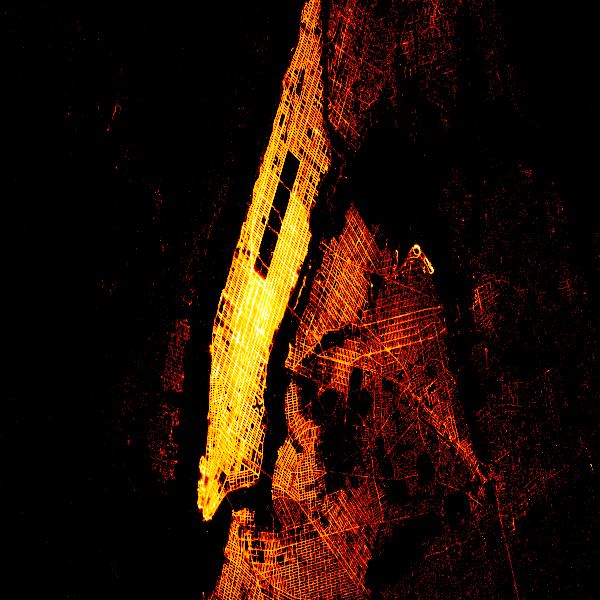

In [8]:
%%time
# lay out the canvas
agg = ds.Canvas().points(gdf, 'dropoff_x', 'dropoff_y')
# shade in the picture 
tf.set_background(tf.shade(agg, cmap=fire), "black")

In [9]:
then = time.time()
total_time = then - now

print(f'{int(total_time//60)} min {int(total_time%60)} sec\nTOTAL TIME: {total_time}')

7 min 52 sec
TOTAL TIME: 472.6999247074127


In [10]:
# see how GPU is doing
!nvidia-smi
# clear up GPU memory
del gdf
# see how GPU is doing
!nvidia-smi

Sun Feb  2 11:43:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |  13173MiB / 15079MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# EXTRA

In [1]:
%%time
from blazingsql import BlazingContext
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf
# start up BalzingSQL
bc = BlazingContext()

BlazingContext ready
CPU times: user 11.1 s, sys: 957 ms, total: 12 s
Wall time: 15.3 s


In [2]:
# list of direct paths for all months
paths = [f'/home/jupyter-winston/turbo-telegram/data/taxi_0{i}.csv' if i < 10 
         else f'/home/jupyter-winston/turbo-telegram/data/taxi_{i}.csv' for i in range(1, 9)]

In [3]:
%%time
# make table from all 12 months at once
# bc.create_table('big_taxi', '/home/jupyter-winston/turbo-telegram/data/taxi_*.csv', header=0)
bc.create_table('big_taxi', paths, header=0)

CPU times: user 3 ms, sys: 7.6 ms, total: 10.6 ms
Wall time: 10.9 ms


CPU times: user 25.9 s, sys: 16.3 s, total: 42.2 s
Wall time: 1min 4s


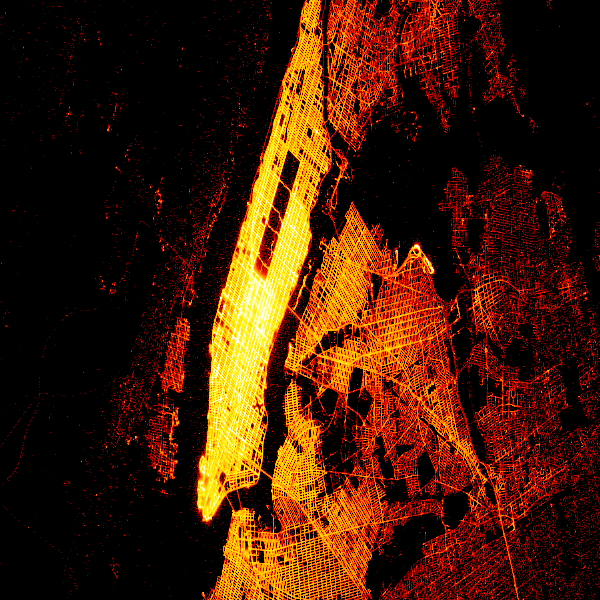

In [4]:
%%time
# visualize dropoff points 
agg = ds.Canvas().points(bc.sql('select dropoff_x, dropoff_y from big_taxi'), 'dropoff_x', 'dropoff_y')
# shade in & display picture
tf.set_background(tf.shade(agg, cmap=fire), "black")